In [1]:
import numpy as np

from matplotlib import pyplot as plt

from openhsl.build.builder import HSBuilder
from openhsl.base.hsi import HSImage

## Сборка ГСИ из сырых данных

Для сборки ГСИ требуется воспользоваться классом HSBuilder.

При инициализации класса указывается путь к сырым ГС данным и формат этих данных:
- path_to_data принимает строковое представление пути к данным;
- path_to_gps принимает путь к GPS-данным в формате CSV для сборки с учетом траектории;
- path_to_metadata принимает путь к JSON файлу, содержащему информацию для формирования ГСИ;
- data_type принимает строковое представление типа данных 'video' или 'image'.

Далее у объекта данного класса вызывается метод build с указанием требуемых параметров сборки:

- norm_rotation=False Если пользователь знает, что спектральная развертка была повернута на небольшой угол во время съемки относительно матрицы, и требуется коррекция данного искажения
- principal_slices=None Если требуется сжать количество спектральных каналов до меньшего диапазона (может использоваться для уменьшения времени сборки на борту БПЛА, но потребует коррекции списка длин волн)

#### 1) Формирование из видеофайла

1. Укажем путь и тип данных в объекте сборщика HSBuilder;
2. Вызовем метод build и укажем требуемые параметры сборки (можно не указывать, тогда они будут выставлены по-умолчанию);
3. Вернем собранное ГСИ из сборщика с помощью метода get_hsi

In [2]:
hsb_video = HSBuilder(path_to_data='test_data/builder/video/rec_2022-06-06-12-24-02.avi',
                      path_to_metadata='build_metadata.json',
                      data_type='video')

hsb_video.build()
hsi_video = hsb_video.get_hsi()

Preprocessing frames: 100%|███████████████████████████████████████████████████████| 1001/1001 [00:02<00:00, 480.51it/s]


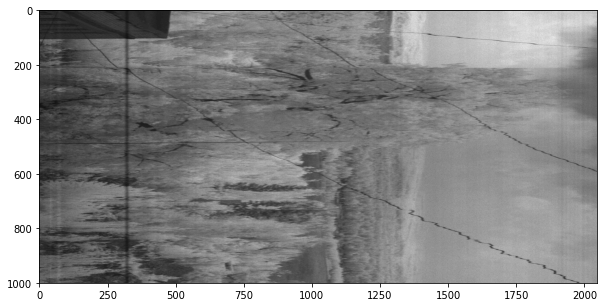

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_video[100], cmap='gray')

Как видно, исходное изображение перевернуто. Воспользуемся встроенным методом объекта HSImage и повернем ГСИ на 90 градусов против часовой стрелки

In [4]:
hsi_video.rot90()

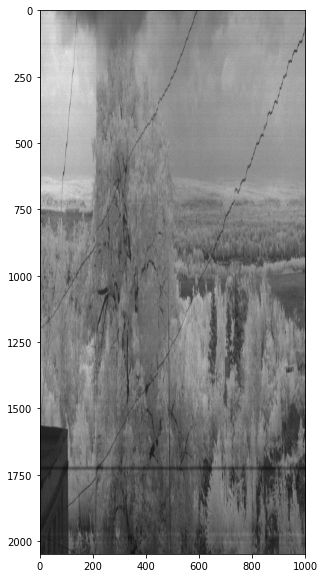

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_video[100], cmap='gray')

#### 2) Формирование ГСИ из набора изображений
1. Укажем путь и тип данных в объекте сборщика HSBuilder;
2. Вызовем метод build и укажем требуемые параметры сборки;
3. Вернем собранное ГСИ из сборщика с помощью метода get_hsi

In [6]:
hsb_imgs = HSBuilder(path_to_data='test_data/builder/imgs',
                     path_to_metadata='microscope_build_metadata.json',
                     data_type='images')

hsb_imgs.build(norm_rotation=True)

hsi_imgs = hsb_imgs.get_hsi()

Preprocessing frames: 100%|██████████████████████████████████████████████████████████| 300/300 [00:34<00:00,  8.64it/s]


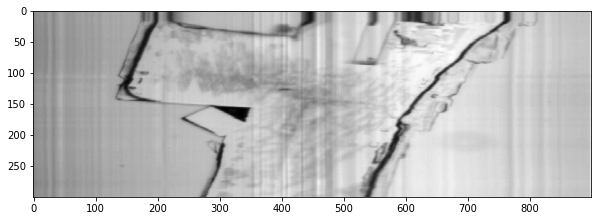

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_imgs[130], cmap='gray')

#### 3) Сборка из данных коптера (видео + gps)

1. Укажем путь и тип данных в объекте сборщика HSBuilder;
2. Вызовем метод build и укажем требуемые параметры сборки;
3. Вернем собранное ГСИ из сборщика с помощью метода get_hsi

In [8]:
hsb_uav = HSBuilder(path_to_data='test_data/builder/copter/',
                    path_to_gps='test_data/builder/copter/gps_2021-03-30.csv',
                    path_to_metadata='uav_build_metadata.json',
                    data_type='video')

hsb_uav.build(principal_slices=50)
hsi_uav = hsb_uav.get_hsi()

Preprocessing frames: 100%|██████████████████████████████████████████████████████| 2507/2507 [00:02<00:00, 1139.94it/s]


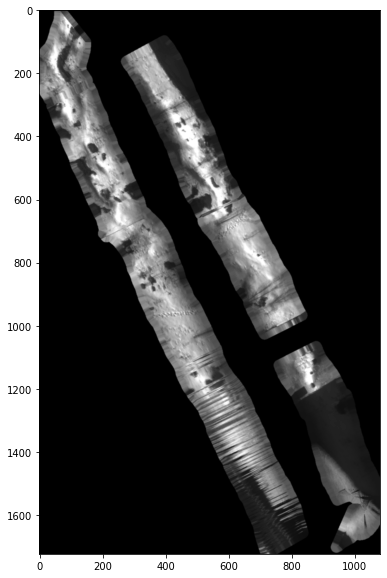

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_uav[25], cmap='gray')

## Сохранение и чтение ГСИ

при сохранении ГСИ рядом с файлом появляется файл с метаданными (в нем содержится информация о длинах волн), например:

hsi.mat
hsi_metadata.json

при чтении из файла будет произведен поиск лежащего рядом файла с метаданными и при его отсутствии поле wavelengths будет инициализировано пустым списком

#### 1) Сохранение и чтение из mat-файла

In [10]:
# Генерируем набор длин волн как стаб-данные
hsi_video.wavelengths = list(np.linspace(420, 980, 250))

hsi_video.save_to_mat(path_to_file='out/hsi_video.mat',
                mat_key='image')

hsi_video.load_from_mat(path_to_file='out/hsi_video.mat',
                  mat_key='image')

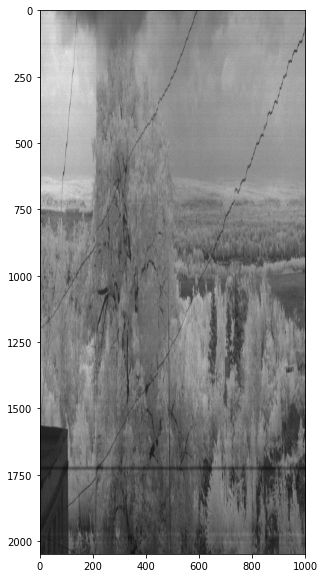

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_video[100], cmap='gray')

#### 2) Сохранение и чтение из h5-файла

In [12]:
hsi_uav.wavelengths = list(np.linspace(420, 980, 50))

hsi_uav.save(path_to_data='out/hsi_uav.h5',
             key='image')

hsi_uav.load(path_to_data='out/hsi_uav.h5',
             key='image')

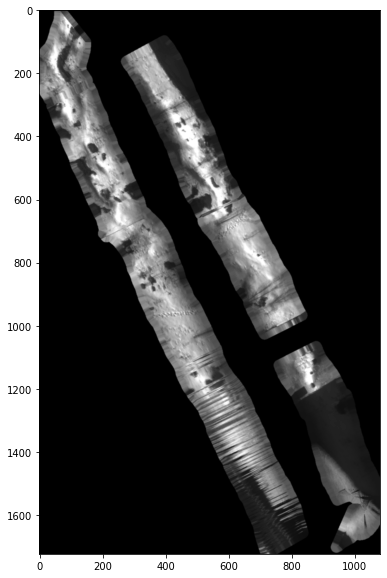

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_uav[25], cmap='gray')

#### 3) Сохранение и чтение из набора изображений (по-канально)

In [14]:
hsi_imgs.wavelengths = list(np.linspace(420, 980, 50))
hsi_imgs.save(path_to_data='out/imgs', img_format='bmp')
#hsi_imgs.save(path_to_data='out/imgs_metadata.json')

hsi_imgs.load(path_to_data='out/imgs')

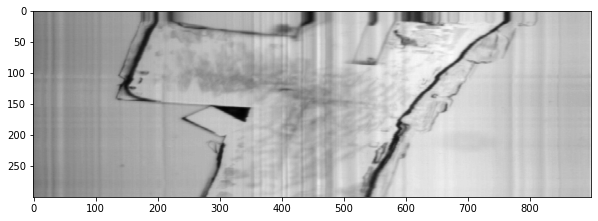

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_imgs[25], cmap='gray')

#### 4) Сохранение и чтение из npy файла

In [16]:
hsi_uav.wavelengths = list(np.linspace(420, 980, 50))

hsi_uav.save(path_to_data='out/hsi_uav.npy')

hsi_uav.load(path_to_data='out/hsi_uav.npy')

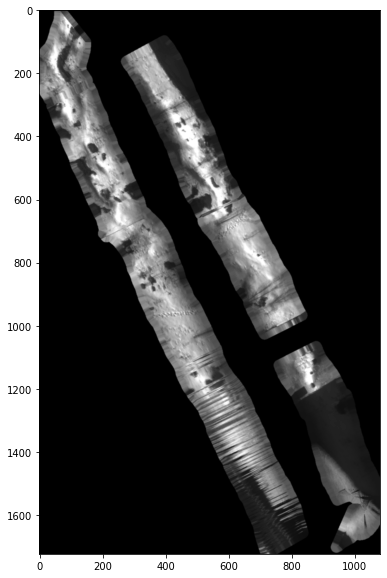

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_uav[25], cmap='gray')

#### 5) Сохранение и чтение из tiff файла

In [18]:
hsi_uav.wavelengths = list(np.linspace(420, 980, 50))

hsi_uav.save(path_to_data='out/hsi_uav.tiff')

hsi_uav.load(path_to_data='out/hsi_uav.tiff')

c:\users\firsov\appdata\local\programs\python\python39\lib\site-packages\rasterio\__init__.py:341: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
c:\users\firsov\appdata\local\programs\python\python39\lib\site-packages\rasterio\__init__.py:331: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


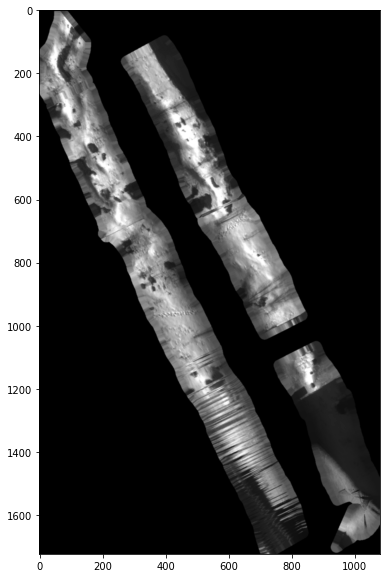

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(hsi_uav[25], cmap='gray')